In [36]:
import glob
import pandas as pd
import numpy as np
import scanpy as sc
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pathlib
import celltypist
from celltypist import models
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 10,
    'font.family': "Arial",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 100
   }

mpl.rcParams.update(params)

sns.set_style("ticks")
sns.set_context(context='paper')
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
mpl.rc('savefig', dpi=300)
output_dir='../../figures/QCandAnnotation'
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(format='pdf', transparent=True,)
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20) 
pd.set_option('display.width', 100)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
%run ../_helper.py

## Prepare BCD object from raw data

In [2]:
file = '/home/michaelswift/repos/shared_data/BCD/scirpy_processed.h5ad'
adata = sc.read_h5ad(file)


KeyboardInterrupt: 

In [ ]:
adata = adata[adata.obs.has_ir == "True"]

In [ ]:
adata.obs = adata.obs[['sample_uid', 'simple_mutation_status']]

sample_uid_tissue_dictionary = {'L01_Input': "PB", 'L04_T4': "Activated PB", 'L06_T8': "Activated PB", 'L08_T12': "Activated PB", 'BMPC_L1':"BMPC", 'BMPC_L2':"BMPC", '10K_BMMNC':"BM", '10K_PBMC':"PB", '20K_PBMC': "PB"}

adata.obs.loc[:,"tissue"] = adata.obs.sample_uid.map(sample_uid_tissue_dictionary)

sample_uid_donor_dictionary = {'L01_Input': "SBC5.x", 'L04_T4': "SBC5.x", 
                               'L06_T8': "SBC5.x", 'L08_T12': "SBC5.x", 
                               'BMPC_L1':"AC0", 'BMPC_L2':"AC0", '10K_BMMNC':"TXG1", 
                               '10K_PBMC':"TXG2", '20K_PBMC': "TXG3"}

adata.obs.loc[:,"donor"] = adata.obs.sample_uid.map(sample_uid_donor_dictionary)

In [ ]:
adata.layers["umi_counts"] = adata.X.copy()

In [41]:
umap_vars = ['sample_uid','global_leiden']

In [42]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata, chunk_size = 10000)
adata.uns['log1p'] = {"base":np.e}

adata.raw = adata

In [43]:
# write the data
adata.write_h5ad('/home/michaelswift/repos/shared_data/pipeline_outs/swift_etal.h5ad')

... storing 'tissue' as categorical
... storing 'donor' as categorical


In [44]:
adata.uns['log1p']['base']

2.718281828459045

In [45]:
data_path = "/home/michaelswift/repos/shared_data/pipeline_outs/"
tissue = "swift_etal"

for file in glob.glob(data_path+"*"):
    print(file)
    # do the routine:
    # load data
    if tissue in file:
        adata = sc.read_h5ad(file)
        sc.pp.highly_variable_genes(adata, batch_key='sample_uid')
        # remove IGH and IGL variable genes from highly variable genes for clustering analysis 
        adata.var.loc[adata.var.index.str.contains("IGHV|IGLV|IGKV"), 'highly_variable'] = False
        filter_low_abundance_cell_groups = False
        cell_group = "majority_voting"
        if filter_low_abundance_cell_groups:
            select = adata.obs[cell_group].value_counts() > (adata.obs.shape[0] / 1000)
            adata = adata[adata.obs[cell_group].isin(select[select == True].index)]
        predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting=True)
        adata = predictions.to_adata()
        # not sure why this isn't added automatically
        bcells = adata[adata.obs[cell_group].str.contains('B cells|Plasma')]
        bcells.obs.sample_uid.value_counts()

/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_LN.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_PB.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/swift_etal.h5ad


🔬 Input data has 43537 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_BM.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_subsampled.h5ad.gz
/home/michaelswift/repos/shared_data/pipeline_outs/web_summary
/home/michaelswift/repos/shared_data/pipeline_outs/gex_object_SP.h5ad.gz


In [49]:
sc.tl.umap(adata)

In [53]:
sc.tl.leiden(adata)

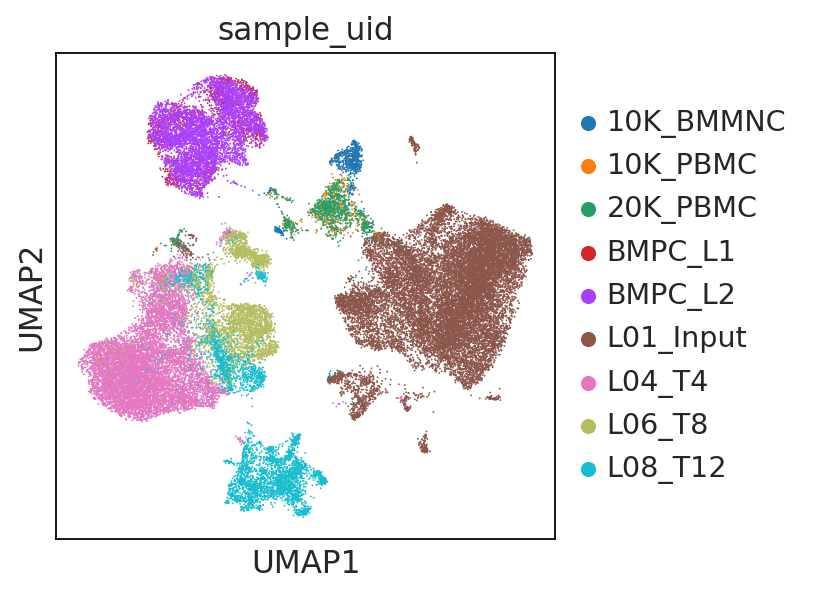

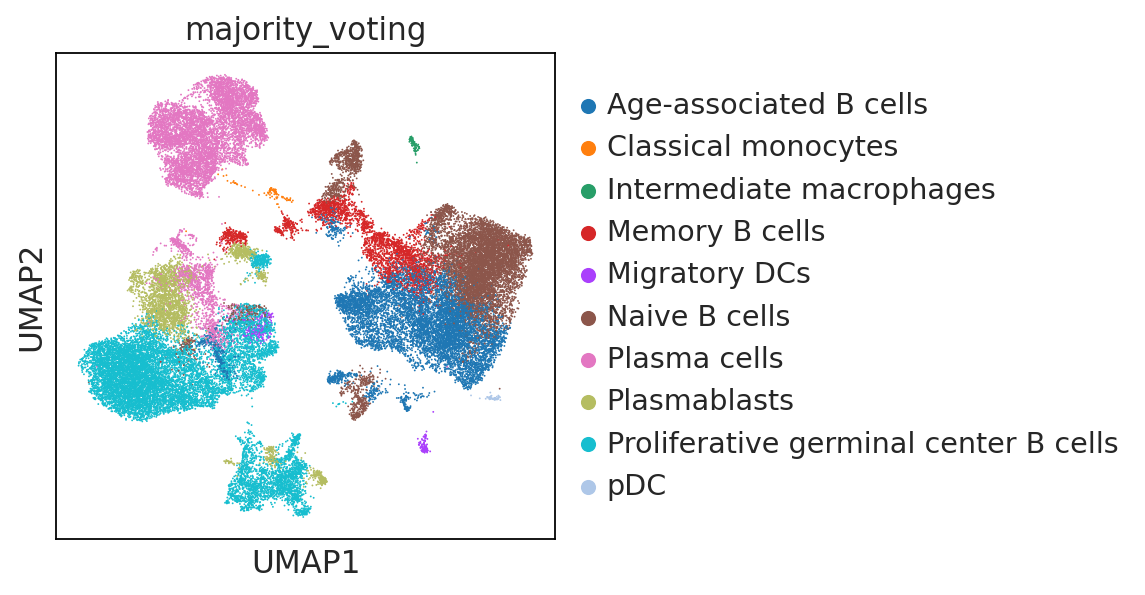

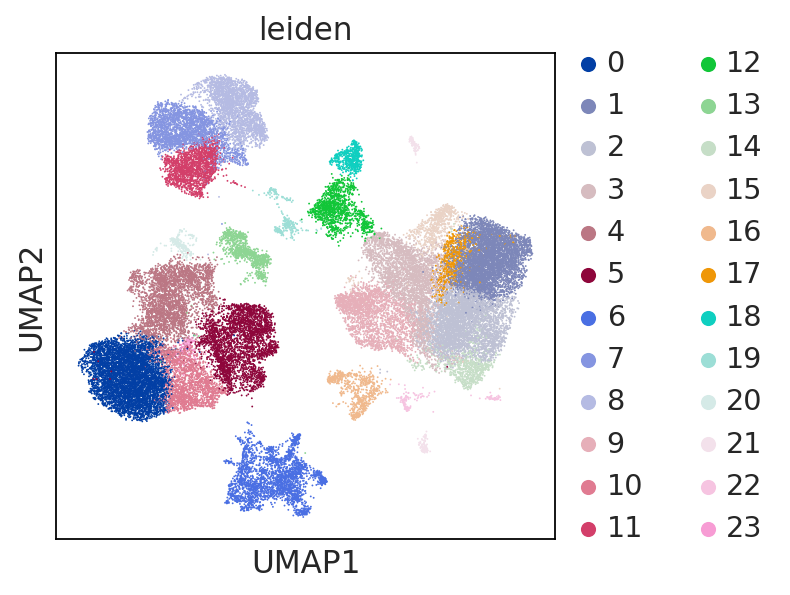

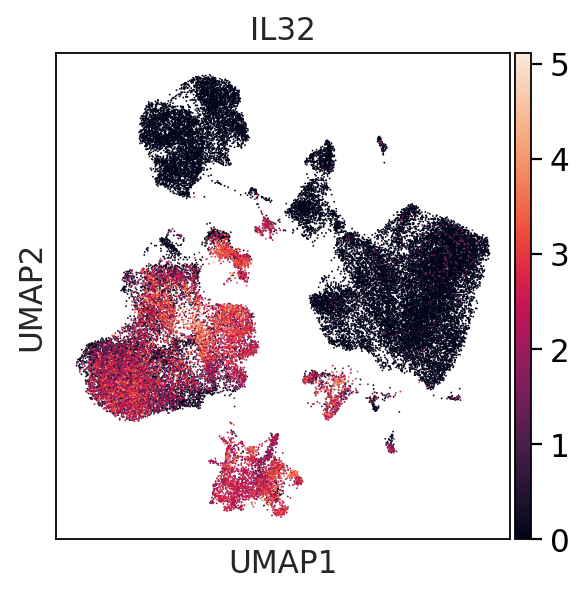

In [62]:
sc.pl.umap(adata, color = 'sample_uid')
sc.pl.umap(adata, color = 'majority_voting')
sc.pl.umap(adata, color = 'leiden')
sc.pl.umap(adata, color = 'IL32')

... storing '13_cluster' as categorical


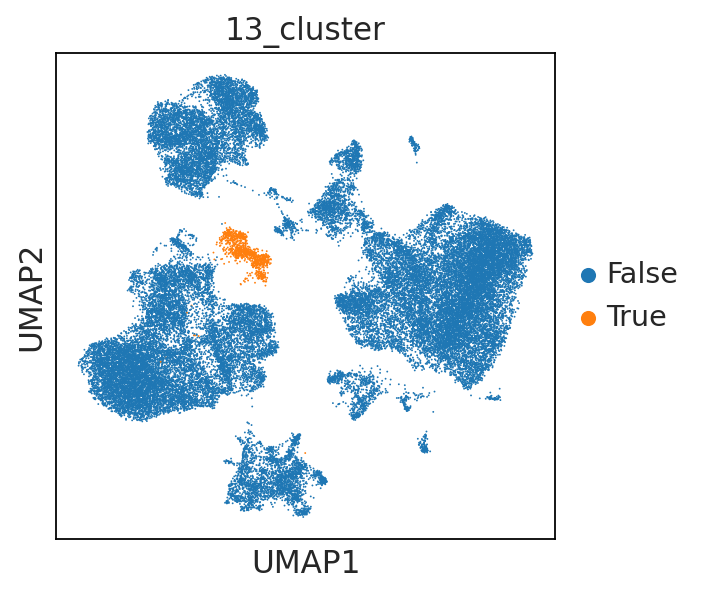

In [58]:
umap_color_1(adata, 'leiden', '13')

/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/michaelswift/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/tools/_rank_gene

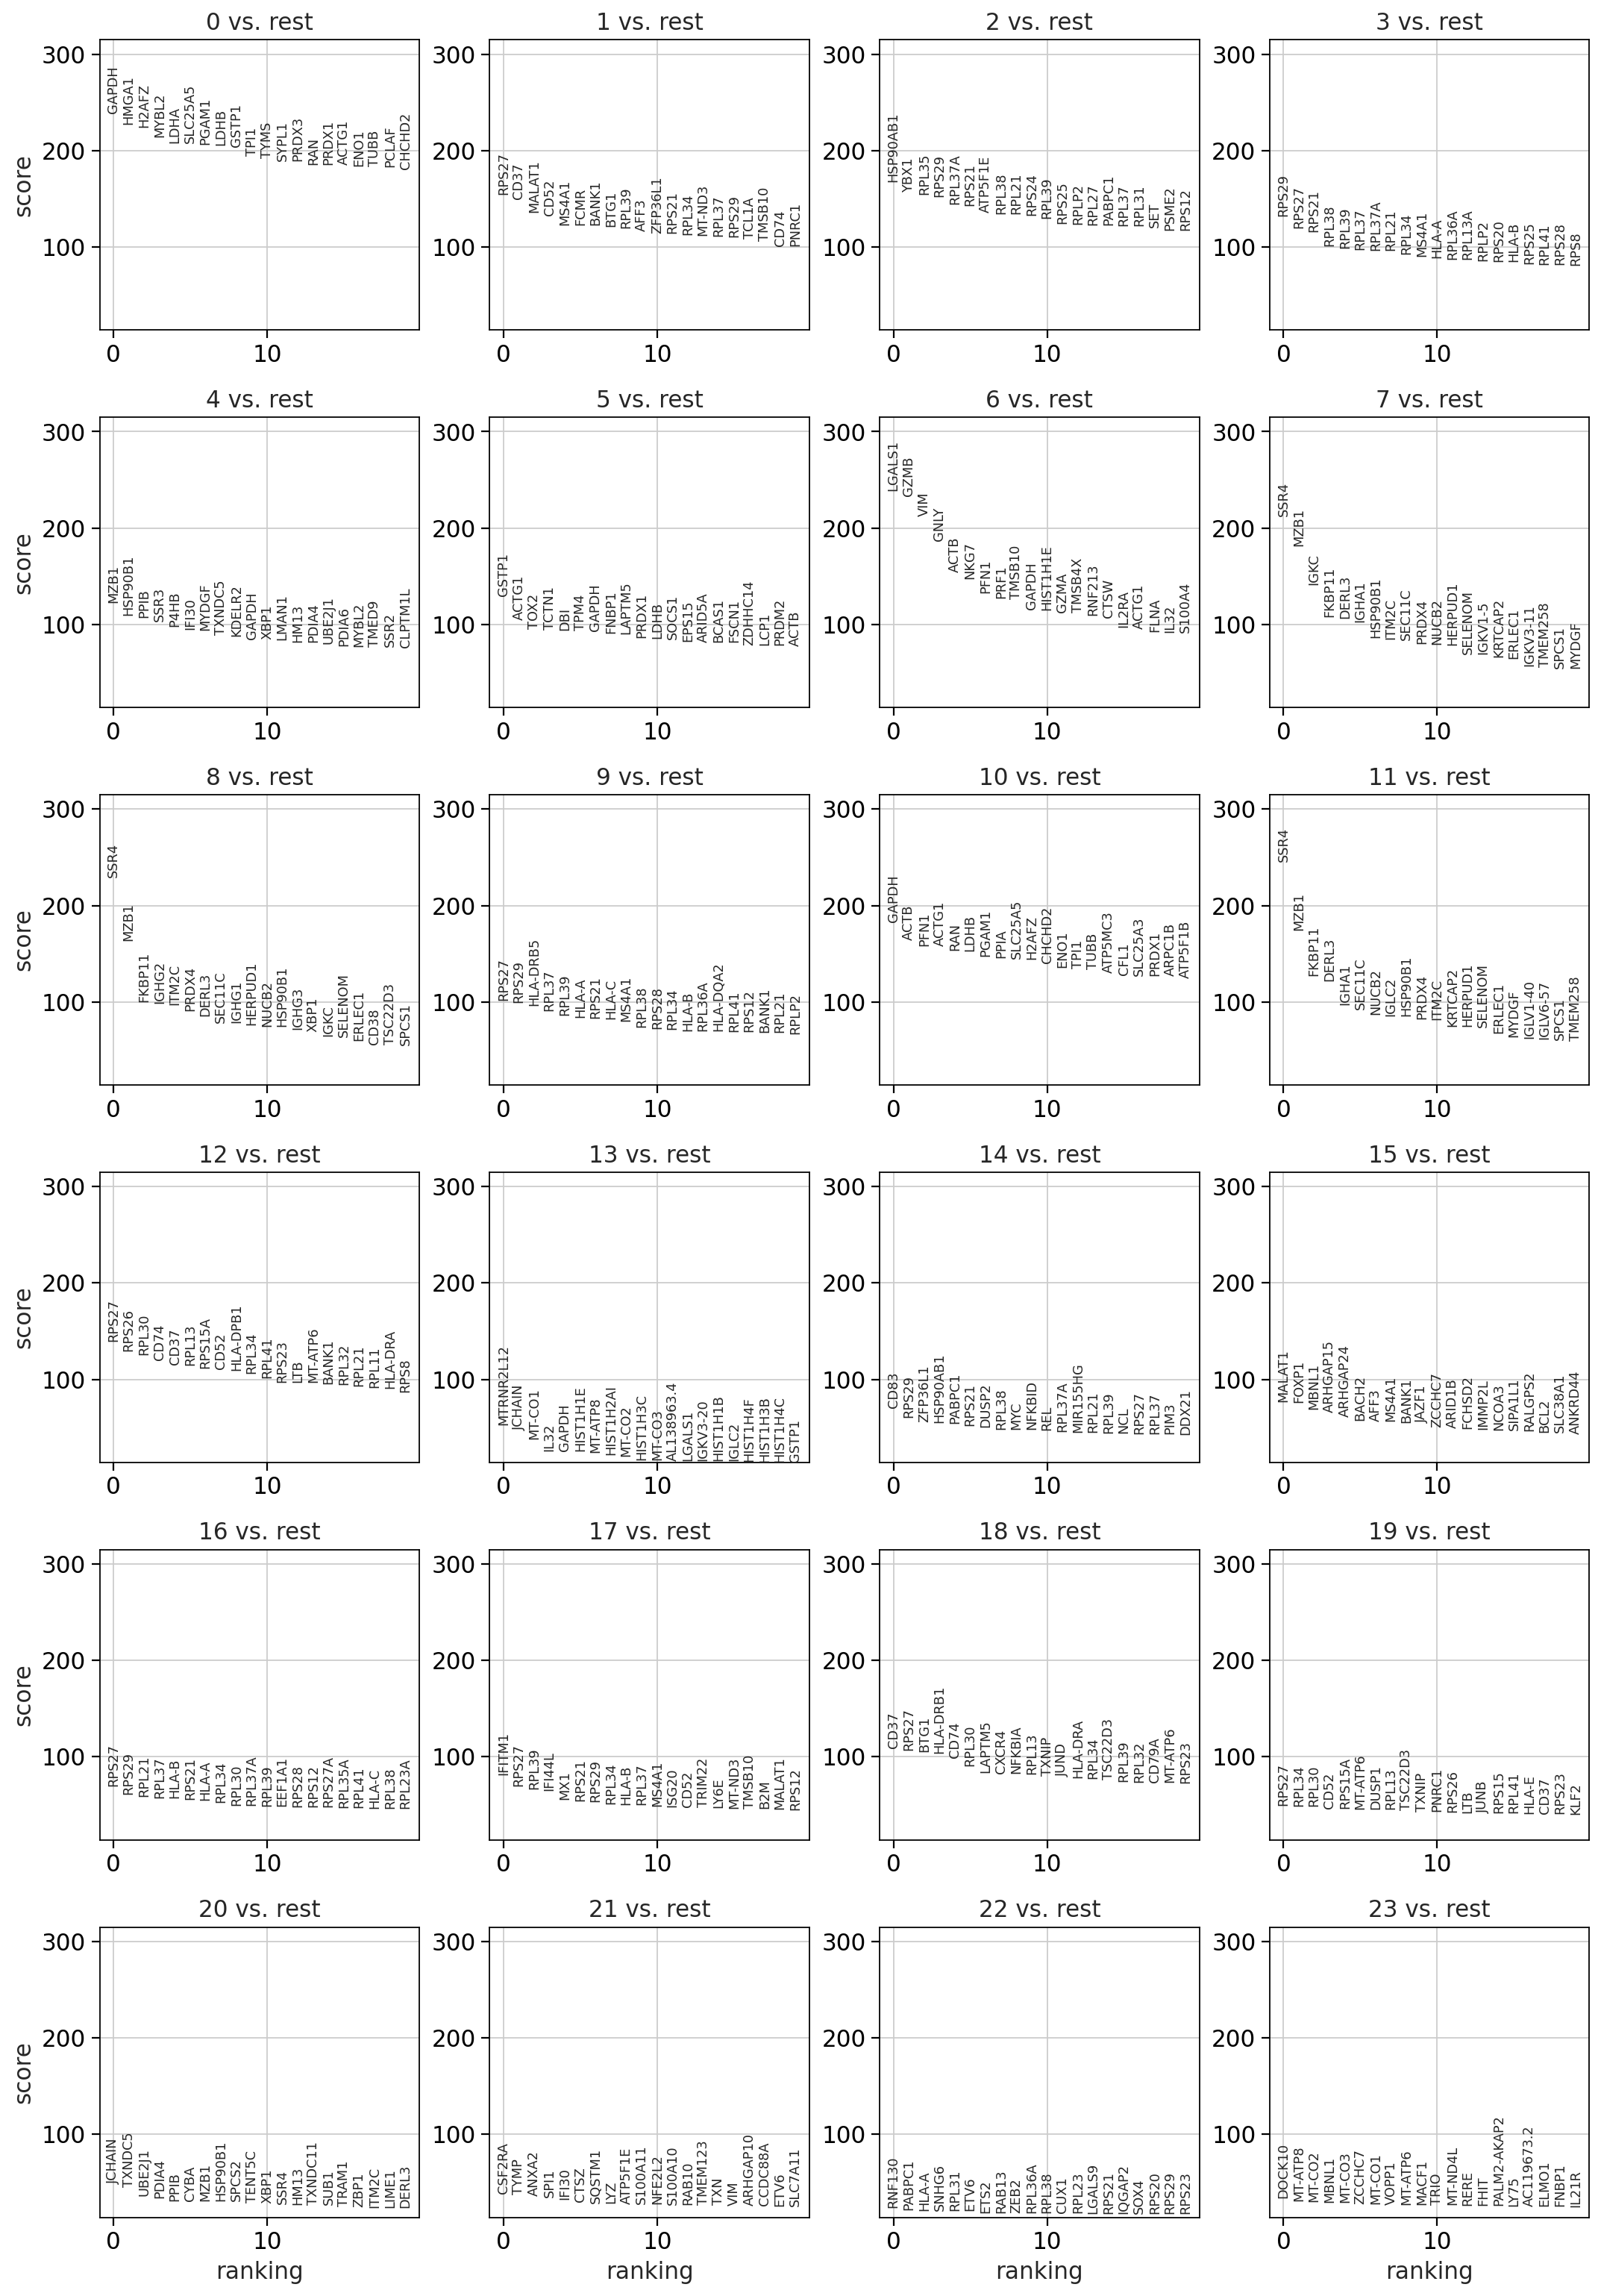

In [61]:
sc.tl.rank_genes_groups(adata, groupby='leiden', reference='rest')

sc.pl.rank_genes_groups(adata)

In [63]:
filter_cells = True

In [69]:
sc.tl.leiden(adata, resolution=0.2)

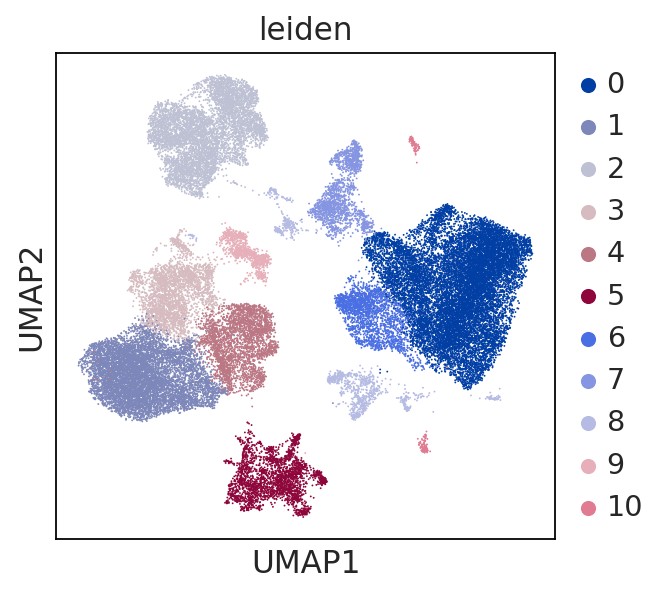

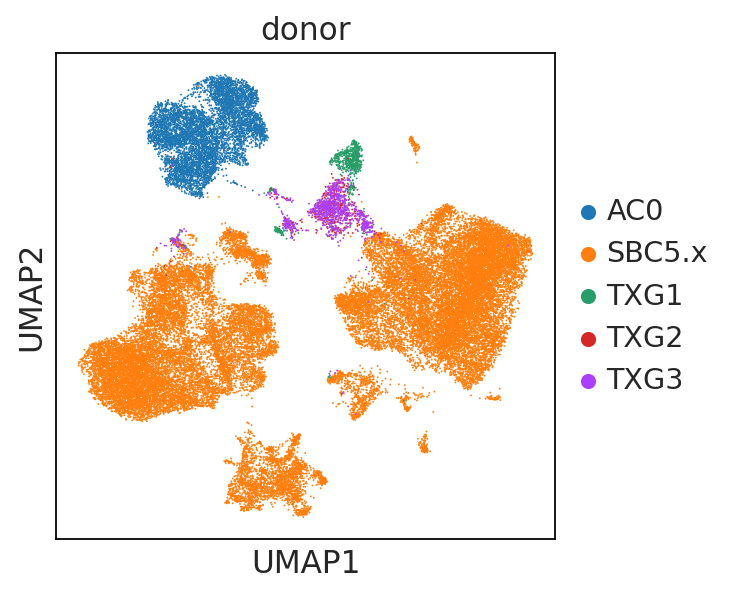

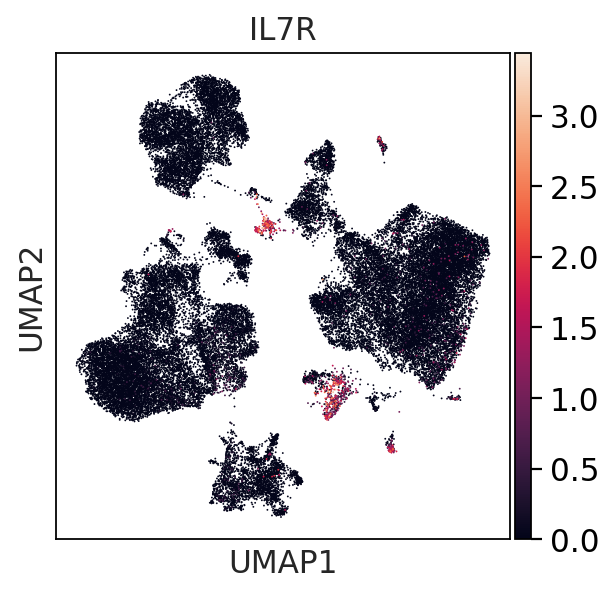

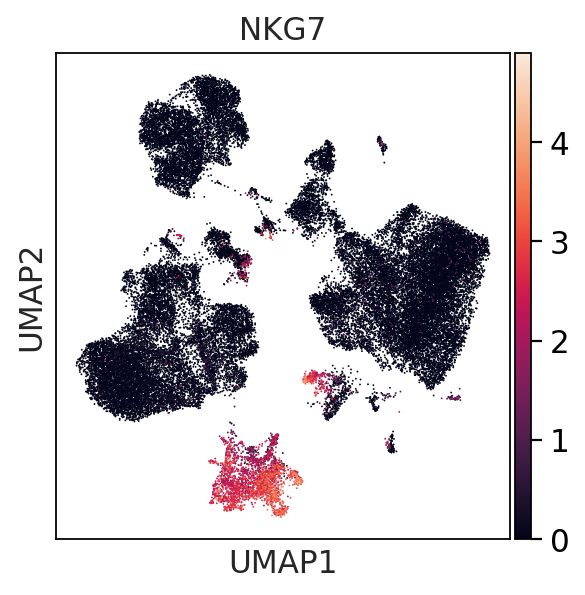

In [70]:
sc.pl.umap(adata, color = 'leiden')
sc.pl.umap(adata, color = 'donor')
sc.pl.umap(adata, color = 'IL7R')
sc.pl.umap(adata, color = 'NKG7')

... storing '5_cluster' as categorical


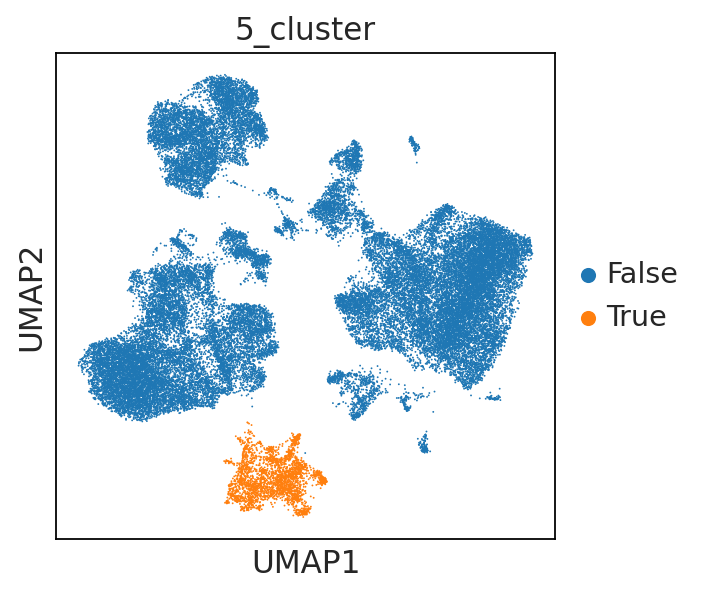

... storing '8_cluster' as categorical


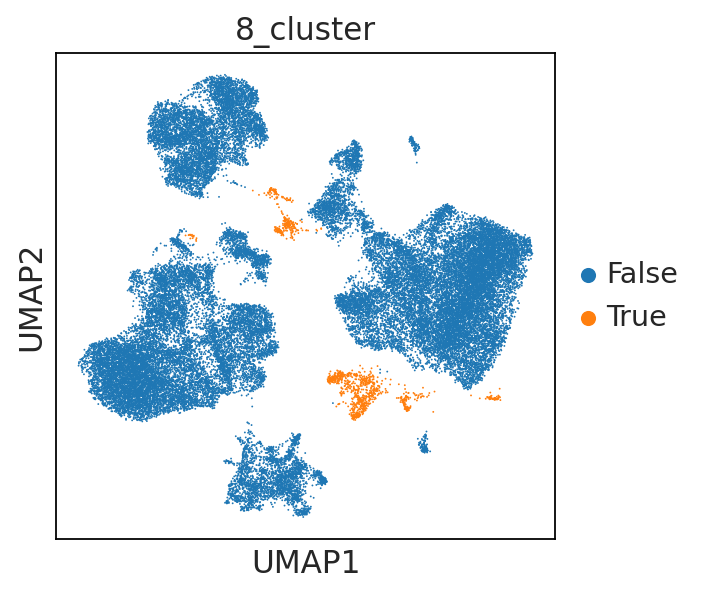

... storing '10_cluster' as categorical


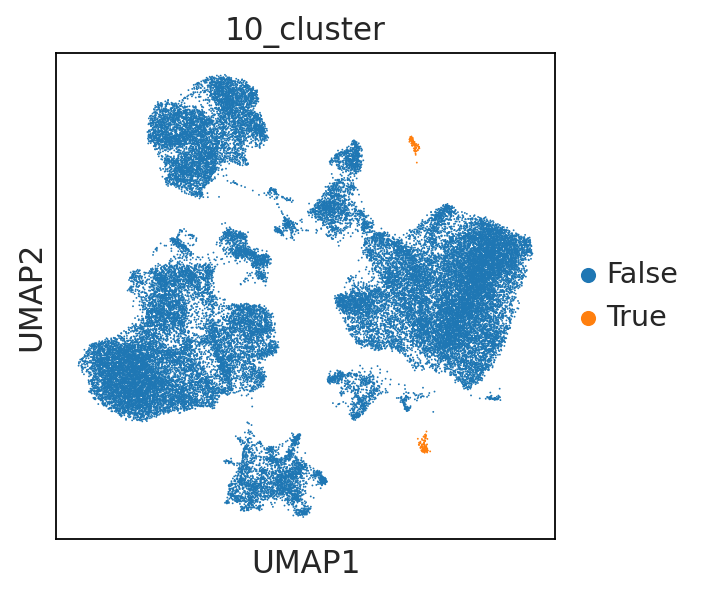

... storing '9_cluster' as categorical


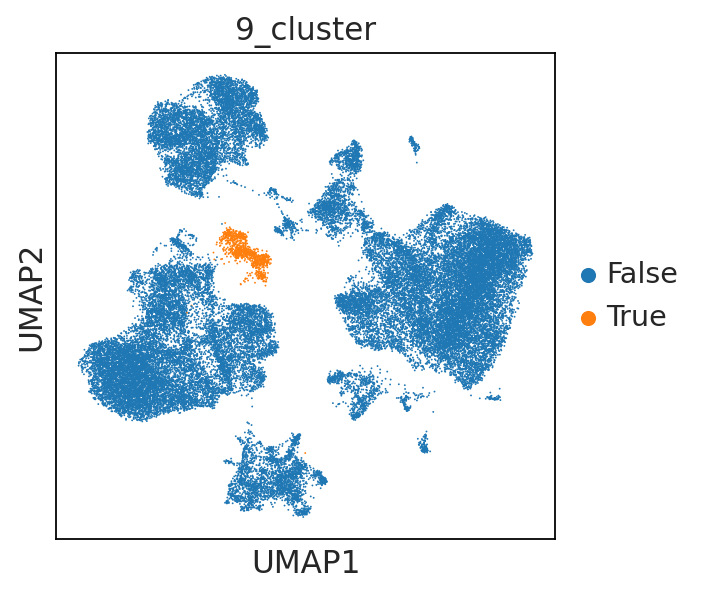

In [72]:
suspect_clusters = ['5', '8', '10', '9']
for i in suspect_clusters:
    umap_color_1(adata, column_name='leiden', variable_name=i)

Plotting umap of filtered cells, for checking that it worked well


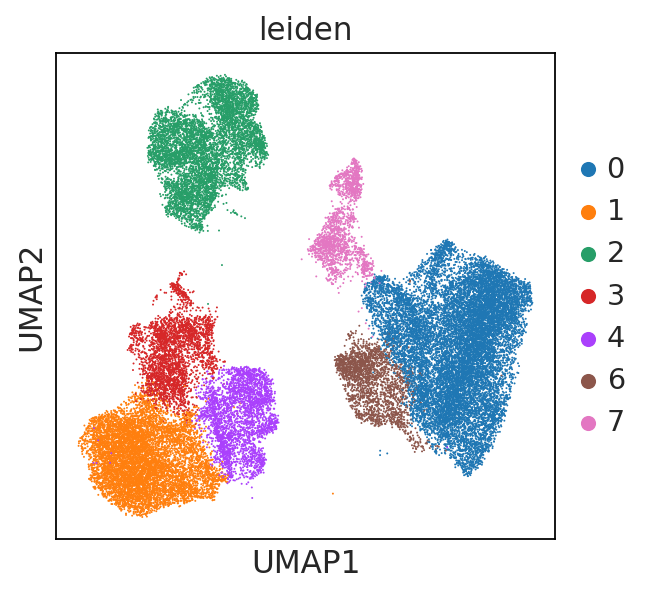

In [75]:
if filter_cells:
    # ad hoc filtering, i think basically these clusters are not plasma or B Cells 
    adata = adata[~adata.obs.leiden.isin(suspect_clusters)]
 
    print("Plotting umap of filtered cells, for checking that it worked well")
    sc.pl.umap(adata, color = 'leiden')
    adata.write_h5ad("{}_Bcells_Filtered.h5ad".format(tissue))

Looks good!